# COMS4061A - Reinforcement Learning

## Markov Decision Processes

- Mamello Seboholi [1851317]

### Imports

In [178]:
import numpy as np
import matplotlib.pyplot as plt

### Utils

In [147]:
Position = tuple[int, int]
Rewards = list[list[int]]

def get_value(array, x, y, default = None):
    if x < 0 or y < 0:
        return default

    if x >= len(array):
        return default

    row = array[x]

    if y >= len(array):
        return default

    return row[y]

def get_accumulated_returns(rewards: list[int], gamma: int = 1):
    returns = 0
    for i, reward in enumerate(rewards):
        returns += reward * (gamma ** i)
    return returns

### Action

In [121]:
class Action:
    def __init__(self, x_modifier, y_modifier, desc = "Action"):
        self.x_modifier = x_modifier
        self.y_modifier = y_modifier
        self.desc = desc

    def __repr__(self):
        return f"{self.desc}"

    def get_new_position(self, x: int, y: int) -> Position:
        return self.x_modifier(x), self.y_modifier(y)

UP = Action(lambda x: x, lambda y: y-1 , desc="UP")
RIGHT = Action(lambda x: x+1, lambda y: y, desc="RIGHT")
DOWN = Action(lambda x: x, lambda y: y+1, desc="DOWN")
LEFT = Action(lambda x: x-1, lambda y: y, desc="LEFT")

### State

In [49]:
class State:
    def __init__(self, x, y, actions):
        self.x = x
        self.y = y
        self.actions = actions

    def __repr__(self):
        return f"\n[y={self.y}][x={self.x}] actions: {[str(action) for action in self.actions]}"
    
States = list[list[State]]
    
def get_states_from_world(world) -> States:
    states = []
    for i, row in enumerate(world):
        states_row = []
        for j, cell in enumerate(row):
            actions = []
            # Terminating State
            if (cell == 1):
                states_row.append(State(j, i, actions))
                continue
            
            # Up
            if (get_value(world, i-1, j, -1) != -1):
                actions.append(UP)

            # Right
            if (get_value(world, i, j+1, -1) != -1):
                actions.append(RIGHT)

            # Down
            if (get_value(world, i+1, j, -1) != -1):
                actions.append(DOWN)

            # Left
            if (get_value(world, i, j-1, -1) != -1):
                actions.append(LEFT)

            states_row.append(State(j, i, actions))
        states.append(states_row)
    return states

### MPD

In [43]:
class MDP:
    def __init__(self, states: States, rewards: Rewards):
        self.states = states
        self.rewards = rewards

    def __str__(self):
        value = "[\n"
        for i, states_row in enumerate(self.states):
            value += "\t[\n"
            for j, state in enumerate(states_row):
                value += f"\t\t{str(state)}{',' if j == len(states_row) -1 else ''}\n"
            value += f"\t]{',' if i == len(self.states) -1 else ''}\n"

        return f"{self.states}"

    def get_state(self, x: int, y: int):
        return self.states[y][x]
    
    def step(self, state: State, action: Action) -> tuple[State, int]:
        next_x, next_y = action.get_new_position(x=state.x, y=state.y)
        return self.get_state(x=next_x, y=next_y), self.rewards[next_y][next_x]

### Agent

In [156]:
class Agent:
    def __init__(self, mdp: MDP):
        self.mdp = mdp
        self.state_trajectory = []
        self.action_trajectory = []
        self.reward_trajectory = []
    
    def run(self, start: tuple[int, int], max_steps: int, policy_func = None):
        start_y, start_x = start
        state = self.mdp.get_state(start_x, start_y)
        
        for i in range(max_steps):
            self.state_trajectory.append(state)
            
            actions = state.actions
            
            # Terminating State
            if len(actions) == 0:
                break
                
            action = np.random.choice(actions) if policy_func == None else policy_func(state)
            self.action_trajectory.append(action)
            
            state, reward = self.mdp.step(state, action)
            self.reward_trajectory.append(reward)

### World Map

- 7x7 grid

Random
[UP, RIGHT, DOWN, UP, LEFT, DOWN, RIGHT, RIGHT, LEFT, LEFT, RIGHT, LEFT, UP, RIGHT, UP, LEFT, RIGHT, RIGHT, RIGHT, DOWN, RIGHT, DOWN, UP, UP, DOWN, RIGHT, LEFT, LEFT, RIGHT, LEFT, UP, DOWN, LEFT, DOWN, UP, RIGHT, UP, DOWN, RIGHT, DOWN, LEFT, UP, LEFT, DOWN, UP, UP, UP, RIGHT, DOWN, UP]

Greedy
[RIGHT, RIGHT, RIGHT, RIGHT, RIGHT, RIGHT, UP, UP, UP, UP, UP, UP, LEFT, LEFT, LEFT, LEFT, LEFT, LEFT]



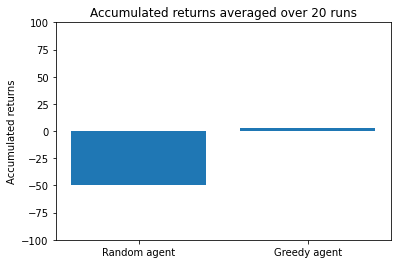

In [192]:
world = [[ 1, 0, 0, 0, 0, 0, 0],
        [ 0, 0, 0, 0, 0, 0, 0 ],
        [ -1, -1, -1, -1, -1, -1, 0 ],
        [ 0, 0, 0, 0, 0, 0, 0 ],
        [ 0, 0, 0, 0, 0, 0, 0 ],
        [ 0, 0, 0, 0, 0, 0, 0 ],
        [ 0, 0, 0, 0, 0, 0, 0 ]]

rewards = np.full((7, 7), -1)
rewards[0][0] = 20

states = get_states_from_world(world)
mdp = MDP(states, rewards)
runs = 20

def policy_func(state: State):
    if state.y == 0:
        return LEFT
    if state.y == 1:
        return UP
    if state.x == 6:
        return UP
    return RIGHT

random_agent_returns = []
for i in range(runs):
    random_agent = Agent(mdp)
    random_agent.run(start=(6, 0), max_steps=50)
    random_agent_returns.append(get_accumulated_returns(random_agent.reward_trajectory))
    
    if i == 0:
        print(f"Random\n{random_agent.action_trajectory}\n")

greedy_agent_returns = []
for i in range(runs):
    greedy_agent = Agent(mdp)
    greedy_agent.run(start=(6, 0), max_steps=50, policy_func=policy_func)
    greedy_agent_returns.append(get_accumulated_returns(greedy_agent.reward_trajectory))
    
    if i == 0:
        print(f"Greedy\n{greedy_agent.action_trajectory}\n")

names = ["Random agent", "Greedy agent"]
values = [np.mean(random_agent_returns), np.mean(greedy_agent_returns)]

plt.bar(names, values)
plt.ylim([-100, 100])
plt.ylabel("Accumulated returns")
plt.title(f"Accumulated returns averaged over {runs} runs")

plt.show()
